# Multivariate Regression WINGOHOCKING MORRIS IT ONLY

# Show the collections that have been generated

In [1]:
from pymongo import MongoClient
from process_collection import *
#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"

client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'2008trial6',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'impervFixed',
 u'impervNotFixed',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'largeTrialLinier',
 u'multivariate_250_2010',
 u'multivariate_random_250_2010',
 u'multivariate_random_250_2011',
 u'multivariate_random_250_2012',
 u'multivariate_random_250_2013',
 u'randomTrial1',
 u'randomTrial2',
 u'randomTrial4',
 u'randomTrial5',
 u'random_multivariate',
 u'random_multivariate2',
 u'random_multivariate2009',
 u'random_multivariate2009year',
 u'random_multivariate2010',
 u'random_multivariate2012year',
 u'random_multivariate250',
 u'random_multivariate250_2009',
 u'random_multivariate3',
 u'random_multivariate5',
 u'random_multivariate6',
 u'random_multivariate7',
 u'random_multiva

In [2]:
from get_cso import calculate_cso
acft_to_mgal = 0.325851  # 1 acre-ft = 0.325851 MGal
collectionName = 'y17m01d12_AEM_45_Subcat_MorrisIT_Only_1'
runs = db[collectionName]
cursor = runs.find()
noLidRun = cursor[0]
noLidVolume = noLidRun['volume']  # 10^6 Gal / yr
noLidPeak = noLidRun['peak']   # cfs
noLidRunoff = noLidRun['runoff']  # acre-ft/yr
outflowSeries = noLidRun['outflow_series']
ratio = 0.05
csoResults = calculate_cso(outflowSeries,ratio)
csoVolumeMGal = csoResults['cso_volume']/1e6
print "noLidPeak = %0.2f cfs, noLidVolume = %0.2f MGal" % (noLidPeak,noLidVolume)
print "noLid Runoff = %0.2f acre-ft = %0.2f MGal" % (noLidRunoff,noLidRunoff*acft_to_mgal)
print "noLid csoVolumeMGal = %0.2f MGal" % csoVolumeMGal
# NOTE: Volume is total flow volume at sewer outlet while Runoff is total runoff volume
#       so they will likely be slightly different
noLidRunParamsList = noLidRun['runParamList']
#print noLidRunParamsList

noLidPeak = 1948.45 cfs, noLidVolume = 1948.90 MGal
noLid Runoff = 5987.73 acre-ft = 1951.11 MGal
noLid csoVolumeMGal = 687.45 MGal


In [47]:
# Compute Annual CSO Flows from results stored on Mongo
from get_cso import * 
from process_collection import * 
collectionName = 'y17m01d12_AEM_45_Subcat_MorrisIT_Only_1'
ratio = 0.05
numSubcatch = 45
numLID = 1
numVariables = numSubcatch*numLID
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName, numVariables, db)
volReduction = results["volReductionList"]
numberOfRuns = len(volReduction)
volReductionMgal = [x / 1e6 for x in volReduction]
numberOfRuns = len(volReductionMgal)
#print volReduction
# ALERT:  in cso_reduction, collectionName and numSubCatch is never used !!!
csoResults = cso_reduction(collectionName, ratio, numSubcatch, results) 
csoReduction = csoResults["csoReduction"]
csoReductionMgal = [x / 1e6 for x in csoReduction]
#print csoReductionMgal
cso = csoResults["cso"]
#print cso
totVol = csoResults["totalVol"]
print "Number of Runs stored in Database = %d" % numberOfRuns
#print results['numLists'][0]

Number of Runs stored in Database = 359


In [44]:
# Compute total greened acres for each run and greened acres by LID for each run
%matplotlib inline
import matplotlib.pyplot as plt
gaPerLid = [0.936]
lidNumbers = results['numLists']
greenedAcres = []
lidGreenedAcres = {}
for lid in range(0,numLID):
    lidGreenedAcres[lid] = []
lidTransposed = zip(*lidNumbers)
for run in range(0,numberOfRuns):
    variable = 0
    lidList = lidTransposed[run]
    gaTotalThisRun = 0.0
    for lid in range(0,numLID):
        gaTotalThisLID = 0.0
        for subcat in range(0,numSubcatch):
            numberLID = lidList[variable]
            thisGreenedAcres = gaPerLid[lid]*numberLID
            gaTotalThisRun += thisGreenedAcres
            gaTotalThisLID += thisGreenedAcres
            variable += 1
        lidGreenedAcres[lid].append(gaTotalThisLID)
    greenedAcres.append(gaTotalThisRun)
#print greenedAcres
#print lidGreenedAcres
#print csoReduction
#print [greenedAcres]

In [30]:
#regress CSO reductions for each run vs total greened acres (combining LIDs) for each run
import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

csoReductionVsTotalGreenedAcresStats = reg_m(csoReduction,[greenedAcres])
print "Exact r-squared:"
print csoReductionVsTotalGreenedAcresStats.rsquared
print csoReductionVsTotalGreenedAcresStats.summary()
print csoReductionVsTotalGreenedAcresStats.params


Exact r-squared:
0.991118659905
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.493e+04
Date:                Thu, 12 Jan 2017   Prob (F-statistic):          3.95e-323
Time:                        17:59:29   Log-Likelihood:                -5787.9
No. Observations:                 315   AIC:                         1.158e+04
Df Residuals:                     313   BIC:                         1.159e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1.664e+0

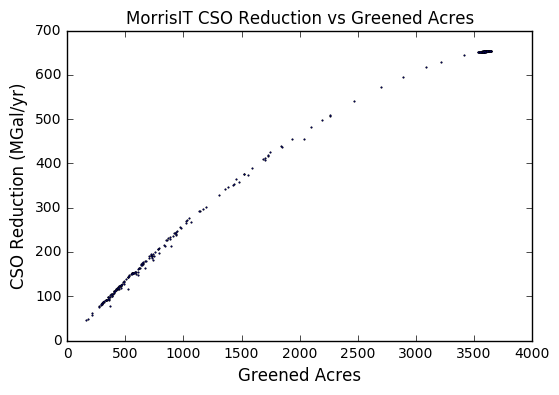

In [45]:
(fig, ax1) = plt.subplots()
plt.title("MorrisIT CSO Reduction vs Greened Acres")
ax1.plot(greenedAcres,csoReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal/yr)",fontsize=12)

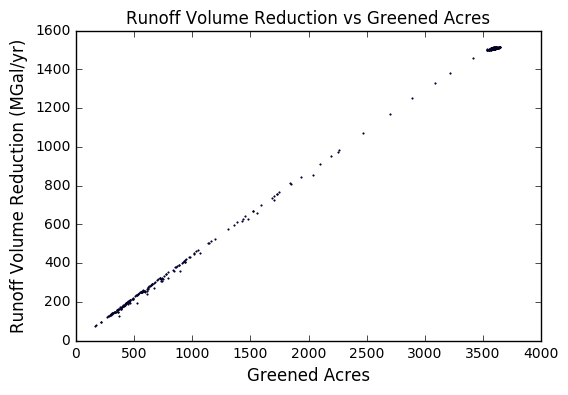

In [46]:
(fig, ax1) = plt.subplots()
plt.title("Runoff Volume Reduction vs Greened Acres")
ax1.plot(greenedAcres,volReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("Runoff Volume Reduction (MGal/yr)",fontsize=12)

Total number of SWMM runs = 327


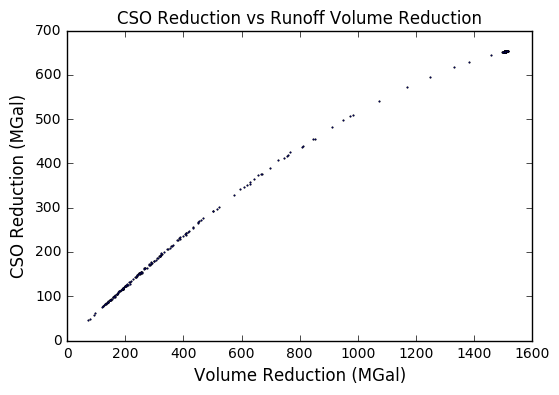

In [40]:
# SCATTER PLOT OF CSO ANNUAL VOLUME REDUCTION VS SEWER OUTFLOW ANNUAL VOLUME REDUCTION
%matplotlib inline
import matplotlib.pyplot as plt
print "Total number of SWMM runs = %d" % len(volReductionMgal)
#xRange = [50,70]
#yRange = [25,45]
(fig, ax1) = plt.subplots()
ax1.plot(volReductionMgal,csoReductionMgal,'ko',color = 'b',markersize = 1)
plt.title("CSO Reduction vs Runoff Volume Reduction")
ax1.set_xlabel("Volume Reduction (MGal)",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal)",fontsize=12)
#plt.xlim(xRange)
#plt.ylim(yRange)

In [41]:
#Single Variable Regression for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

import numpy as np
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    statistics = sm.OLS(y, X).fit()
    return statistics

limitedGreenedAcres = []
limitedCsoReduction = []
for run in range(0,numberOfRuns):
    if greenedAcres[run] <= 2000.0:
        limitedGreenedAcres.append(greenedAcres[run])
        limitedCsoReduction.append(csoReduction[run])

csoReductionVsTotalGreenedAcresStats = reg_m(limitedCsoReduction,[limitedGreenedAcres])
print "Exact r-squared:"
print csoReductionVsTotalGreenedAcresStats.rsquared
print csoReductionVsTotalGreenedAcresStats.summary()
print csoReductionVsTotalGreenedAcresStats.params

Exact r-squared:
0.995659477211
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.762e+04
Date:                Thu, 12 Jan 2017   Prob (F-statistic):          1.18e-195
Time:                        22:02:09   Log-Likelihood:                -2833.1
No. Observations:                 166   AIC:                             5670.
Df Residuals:                     164   BIC:                             5676.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          2.374e+0

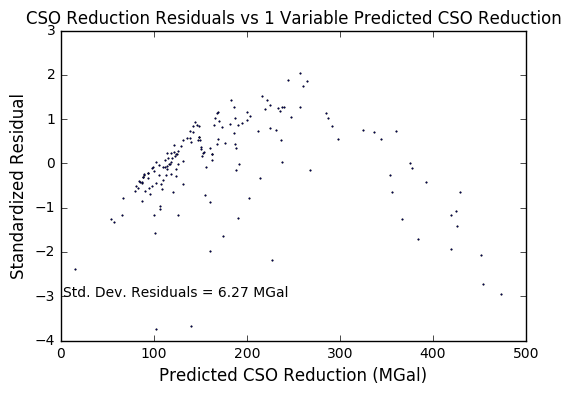

In [42]:
# Generate Residuals Plot for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#print limitedGreenedAcres
#xVals = limitedGreenedAcres
betaZero = csoReductionVsTotalGreenedAcresStats.params[1]
betaOne = csoReductionVsTotalGreenedAcresStats.params[0]
yPredicted = []
residuals = []
for i in range(0,len(limitedGreenedAcres)):
    yVal = betaZero + betaOne*limitedGreenedAcres[i]
    resid = limitedCsoReduction[i] - yVal
    yPredicted.append(yVal)  # Gallons
    residuals.append(resid)  # Gallons
#print yPredicted
yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
stdDevResidualsMGal = stdDevResiduals/1e6
standardizedResiduals = [x / stdDevResiduals for x in residuals]
#print standardizedResiduals
#print yPredictedMGal
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs 1 Variable Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-3,stdDevText)